In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ============================================================================
# 1. DATA LOADING AND FEATURE ENGINEERING
# ============================================================================

now = datetime.now()
start = datetime(now.year-10, now.month, now.day)
end = datetime(now.year, now.month, now.day)

ticker = "AAPL"
print(f"Downloading {ticker} data...")

df = yf.download(ticker, start, end)
df = df.reset_index()

# Feature Engineering - Technical Indicators
def calculate_rsi(data, window=14):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, fast=12, slow=26, signal=9):
    """Calculate MACD indicators"""
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def calculate_bollinger_bands(data, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band, sma

# Add all features
print("Calculating technical indicators...")
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_100'] = df['Close'].rolling(100).mean()
df['MA_200'] = df['Close'].rolling(200).mean()
df['RSI'] = calculate_rsi(df['Close'])
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = calculate_macd(df['Close'])
df['BB_Upper'], df['BB_Lower'], df['BB_Middle'] = calculate_bollinger_bands(df['Close'])
df['Pct_Change'] = df['Close'].pct_change()
df['Volume_MA'] = df['Volume'].rolling(20).mean()
df['Price_Range'] = (df['High'] - df['Low']) / df['Close']

# Drop NaN values
df = df.dropna().reset_index(drop=True)

# Select features for multivariate model
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'MA_50', 'MA_100', 'MA_200', 'RSI',
                   'MACD', 'MACD_Signal', 'MACD_Hist',
                   'BB_Upper', 'BB_Lower', 'BB_Middle',
                   'Pct_Change', 'Volume_MA', 'Price_Range']

print(f"Total features: {len(feature_columns)}")
print(f"Total data points: {len(df)}")


[*********************100%***********************]  1 of 1 completed

Calculating technical indicators...
Total features: 18
Total data points: 2315


In [3]:
df.head(10)

Price,Date,Close,High,Low,Open,Volume,MA_50,MA_100,MA_200,RSI,MACD,MACD_Signal,MACD_Hist,BB_Upper,BB_Lower,BB_Middle,Pct_Change,Volume_MA,Price_Range
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,,,
0,2016-10-11,26.668531,27.216578,26.645599,26.989561,256164000,25.205488,23.761561,23.267047,62.309600,0.385809,0.371238,0.014571,26.644223,25.507551,26.075887,0.002154,172909060.0,0.021410
1,2016-10-12,26.907015,27.053774,26.771724,26.909308,150347200,25.267048,23.813460,23.281159,62.208177,0.419614,0.380914,0.038701,26.779561,25.499938,26.139750,0.008943,158248680.0,0.010482
2,2016-10-13,26.824465,26.929946,26.535536,26.780896,140769600,25.320981,23.861774,23.292694,72.262669,0.434733,0.391677,0.043056,26.848351,25.463481,26.155916,-0.003068,147290440.0,0.014703
3,2016-10-14,26.973513,27.097339,26.858859,27.030840,142608800,25.374914,23.908226,23.306575,73.584751,0.453514,0.404045,0.049469,26.966749,25.407226,26.186987,0.005556,138443500.0,0.008841
4,2016-10-17,26.955168,27.021666,26.778600,26.904720,94499600,25.421097,23.950572,23.322687,72.434537,0.461596,0.415555,0.046041,27.080609,25.384401,26.232505,-0.000680,133763880.0,0.009017
5,2016-10-18,26.936829,27.106516,26.932241,27.099637,98214000,25.462831,23.990933,23.338605,69.214131,0.461205,0.424685,0.036520,27.175942,25.378499,26.277220,-0.000680,131771720.0,0.006470
6,2016-10-19,26.856565,27.003323,26.095263,26.886375,80138400,25.500942,24.030627,23.357098,81.911705,0.449240,0.429596,0.019644,27.245111,25.391192,26.318151,-0.002980,128578000.0,0.033811
7,2016-10-20,26.842808,26.916186,26.675414,26.796947,96503200,25.542493,24.071302,23.377789,78.931677,0.433649,0.430407,0.003242,27.301979,25.390275,26.346127,-0.000512,127188360.0,0.008970
8,2016-10-21,26.737329,26.808416,26.663951,26.785484,92770800,25.582255,24.114115,23.402743,79.737903,0.408078,0.425941,-0.017863,27.331309,25.450145,26.390727,-0.003929,121330660.0,0.005403


In [4]:
# ============================================================================
# 2. PYTORCH LSTM MODEL
# ============================================================================

class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, num_layers=1, dropout=0.2):
        super(MultivariateLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size1,
                             num_layers=num_layers,
                             batch_first=True,
                             dropout=dropout if num_layers > 1 else 0)
        self.dropout1 = nn.Dropout(dropout)

        self.lstm2 = nn.LSTM(input_size=hidden_size1,
                             hidden_size=hidden_size2,
                             num_layers=num_layers,
                             batch_first=True,
                             dropout=dropout if num_layers > 1 else 0)
        self.dropout2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)

        out, _ = self.lstm2(out)
        out = self.dropout2(out)

        # Take only the last time step
        out = out[:, -1, :]

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [5]:
# ============================================================================
# 3. WALK-FORWARD VALIDATION
# ============================================================================

def prepare_sequences(data, features, target_col='Close', lookback=100):
    """Prepare sequences for LSTM"""
    X, y = [], []
    target_idx = features.index(target_col)

    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])  # All features
        y.append(data[i, target_idx])    # Only Close price

    return np.array(X), np.array(y)

def calculate_metrics(y_true, y_pred, y_true_prev):
    """Calculate comprehensive metrics including directional accuracy"""
    # Traditional metrics
    mse = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_pred - y_true))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Directional metrics
    actual_direction = np.sign(y_true - y_true_prev)
    pred_direction = np.sign(y_pred - y_true_prev)

    directional_accuracy = np.mean(actual_direction == pred_direction) * 100

    # Up/Down specific accuracy
    up_mask = actual_direction > 0
    down_mask = actual_direction < 0

    up_accuracy = np.mean(pred_direction[up_mask] == actual_direction[up_mask]) * 100 if np.sum(up_mask) > 0 else 0
    down_accuracy = np.mean(pred_direction[down_mask] == actual_direction[down_mask]) * 100 if np.sum(down_mask) > 0 else 0

    # Confusion matrix for directions
    true_positives = np.sum((actual_direction > 0) & (pred_direction > 0))
    false_positives = np.sum((actual_direction <= 0) & (pred_direction > 0))
    true_negatives = np.sum((actual_direction <= 0) & (pred_direction <= 0))
    false_negatives = np.sum((actual_direction > 0) & (pred_direction <= 0))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy,
        'Up_Accuracy': up_accuracy,
        'Down_Accuracy': down_accuracy,
        'True_Positives': true_positives,
        'False_Positives': false_positives,
        'True_Negatives': true_negatives,
        'False_Negatives': false_negatives
    }

def walk_forward_validation(df, feature_columns, lookback=100, train_size=1000,
                           test_size=50, epochs=20, batch_size=32, learning_rate=0.001):
    """
    Perform walk-forward validation
    """
    print("\n" + "="*80)
    print("WALK-FORWARD VALIDATION")
    print("="*80)

    all_predictions = []
    all_actuals = []
    all_previous = []
    fold_metrics = []

    data_values = df[feature_columns].values

    # Create scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    n_splits = (len(data_values) - train_size - lookback) // test_size
    print(f"\nTotal folds: {n_splits}")
    print(f"Train size: {train_size}, Test size: {test_size}, Lookback: {lookback}\n")

    for fold in range(n_splits):
        train_start = fold * test_size
        train_end = train_start + train_size
        test_end = train_end + test_size

        if test_end > len(data_values):
            break

        print(f"\nFold {fold + 1}/{n_splits}")
        print(f"Train: {train_start} to {train_end} | Test: {train_end} to {test_end}")

        # Scale data
        train_data = data_values[train_start:train_end]
        test_data = data_values[train_start:test_end]  # Include lookback from train

        scaler.fit(train_data)
        train_scaled = scaler.transform(train_data)
        test_scaled = scaler.transform(test_data)

        # Prepare sequences
        X_train, y_train = prepare_sequences(train_scaled, feature_columns, lookback=lookback)
        X_test, y_test = prepare_sequences(test_scaled, feature_columns, lookback=lookback)

        # Get previous values for directional metrics
        y_test_prev = test_scaled[lookback-1:-1, feature_columns.index('Close')]

        # Convert to tensors
        X_train = torch.FloatTensor(X_train).to(device)
        y_train = torch.FloatTensor(y_train).to(device)
        X_test = torch.FloatTensor(X_test).to(device)

        # Initialize model
        model = MultivariateLSTM(input_size=len(feature_columns)).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        model.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f'  Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.6f}')

        # Prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).cpu().numpy().flatten()

        # Inverse transform (only Close column)
        close_scaler = MinMaxScaler(feature_range=(0, 1))
        close_scaler.fit(train_data[:, feature_columns.index('Close')].reshape(-1, 1))

        y_pred_inv = close_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_test_prev_inv = close_scaler.inverse_transform(y_test_prev.reshape(-1, 1)).flatten()

        # Store results
        all_predictions.extend(y_pred_inv)
        all_actuals.extend(y_test_inv)
        all_previous.extend(y_test_prev_inv)

        # Calculate fold metrics
        metrics = calculate_metrics(y_test_inv, y_pred_inv, y_test_prev_inv)
        fold_metrics.append(metrics)

        print(f"  Fold RMSE: ${metrics['RMSE']:.2f} | Directional Acc: {metrics['Directional_Accuracy']:.2f}%")

    return np.array(all_predictions), np.array(all_actuals), np.array(all_previous), fold_metrics


In [6]:
# ============================================================================
# 4. RUN WALK-FORWARD VALIDATION
# ============================================================================
start_time = datetime.now()

predictions, actuals, previous, fold_metrics = walk_forward_validation(
    df=df,
    feature_columns=feature_columns,
    lookback=100,
    train_size=1000,
    test_size=50,
    epochs=20,
    batch_size=32,
    learning_rate=0.001
)

end_time = datetime.now()
print(f"\nTotal time taken: {end_time - start_time}")


WALK-FORWARD VALIDATION

Total folds: 24
Train size: 1000, Test size: 50, Lookback: 100


Fold 1/24
Train: 0 to 1000 | Test: 1000 to 1050
  Epoch [5/20], Loss: 0.001212
  Epoch [10/20], Loss: 0.000674
  Epoch [15/20], Loss: 0.000742
  Epoch [20/20], Loss: 0.001222
  Fold RMSE: $2.68 | Directional Acc: 52.21%

Fold 2/24
Train: 50 to 1050 | Test: 1050 to 1100
  Epoch [5/20], Loss: 0.001290
  Epoch [10/20], Loss: 0.001103
  Epoch [15/20], Loss: 0.000781
  Epoch [20/20], Loss: 0.001096
  Fold RMSE: $3.46 | Directional Acc: 54.00%

Fold 3/24
Train: 100 to 1100 | Test: 1100 to 1150
  Epoch [5/20], Loss: 0.002208
  Epoch [10/20], Loss: 0.001823
  Epoch [15/20], Loss: 0.001288
  Epoch [20/20], Loss: 0.001256
  Fold RMSE: $2.66 | Directional Acc: 51.37%

Fold 4/24
Train: 150 to 1150 | Test: 1150 to 1200
  Epoch [5/20], Loss: 0.002371
  Epoch [10/20], Loss: 0.001613
  Epoch [15/20], Loss: 0.001295
  Epoch [20/20], Loss: 0.001538
  Fold RMSE: $3.44 | Directional Acc: 49.89%

Fold 5/24
Train: 200

In [7]:
# ============================================================================
# 5. AGGREGATE RESULTS AND METRICS
# ============================================================================

print("\n" + "="*80)
print("FINAL RESULTS - WALK-FORWARD VALIDATION")
print("="*80)

overall_metrics = calculate_metrics(actuals, predictions, previous)

print("\n📊 TRADITIONAL METRICS:")
print(f"  RMSE: ${overall_metrics['RMSE']:.2f}")
print(f"  MAE: ${overall_metrics['MAE']:.2f}")
print(f"  MAPE: {overall_metrics['MAPE']:.2f}%")

print("\n🎯 PROBABILISTIC METRICS:")
print(f"  Directional Accuracy: {overall_metrics['Directional_Accuracy']:.2f}%")
print(f"  Up Movement Accuracy: {overall_metrics['Up_Accuracy']:.2f}%")
print(f"  Down Movement Accuracy: {overall_metrics['Down_Accuracy']:.2f}%")

print("\n📈 CONFUSION MATRIX (Direction):")
print(f"  True Positives (Up predicted Up): {overall_metrics['True_Positives']}")
print(f"  False Positives (Down predicted Up): {overall_metrics['False_Positives']}")
print(f"  True Negatives (Down predicted Down): {overall_metrics['True_Negatives']}")
print(f"  False Negatives (Up predicted Down): {overall_metrics['False_Negatives']}")

# Per-fold statistics
print("\n📉 PER-FOLD STATISTICS:")
rmse_values = [m['RMSE'] for m in fold_metrics]
dir_acc_values = [m['Directional_Accuracy'] for m in fold_metrics]

print(f"  RMSE - Mean: ${np.mean(rmse_values):.2f}, Std: ${np.std(rmse_values):.2f}")
print(f"  Directional Accuracy - Mean: {np.mean(dir_acc_values):.2f}%, Std: {np.std(dir_acc_values):.2f}%")



FINAL RESULTS - WALK-FORWARD VALIDATION

📊 TRADITIONAL METRICS:
  RMSE: $4.62
  MAE: $3.38
  MAPE: 2.95%

🎯 PROBABILISTIC METRICS:
  Directional Accuracy: 52.09%
  Up Movement Accuracy: 48.47%
  Down Movement Accuracy: 56.49%

📈 CONFUSION MATRIX (Direction):
  True Positives (Up predicted Up): 5883
  False Positives (Down predicted Up): 4641
  True Negatives (Down predicted Down): 6022
  False Negatives (Up predicted Down): 6254

📉 PER-FOLD STATISTICS:
  RMSE - Mean: $4.45, Std: $1.23
  Directional Accuracy - Mean: 52.09%, Std: 2.54%


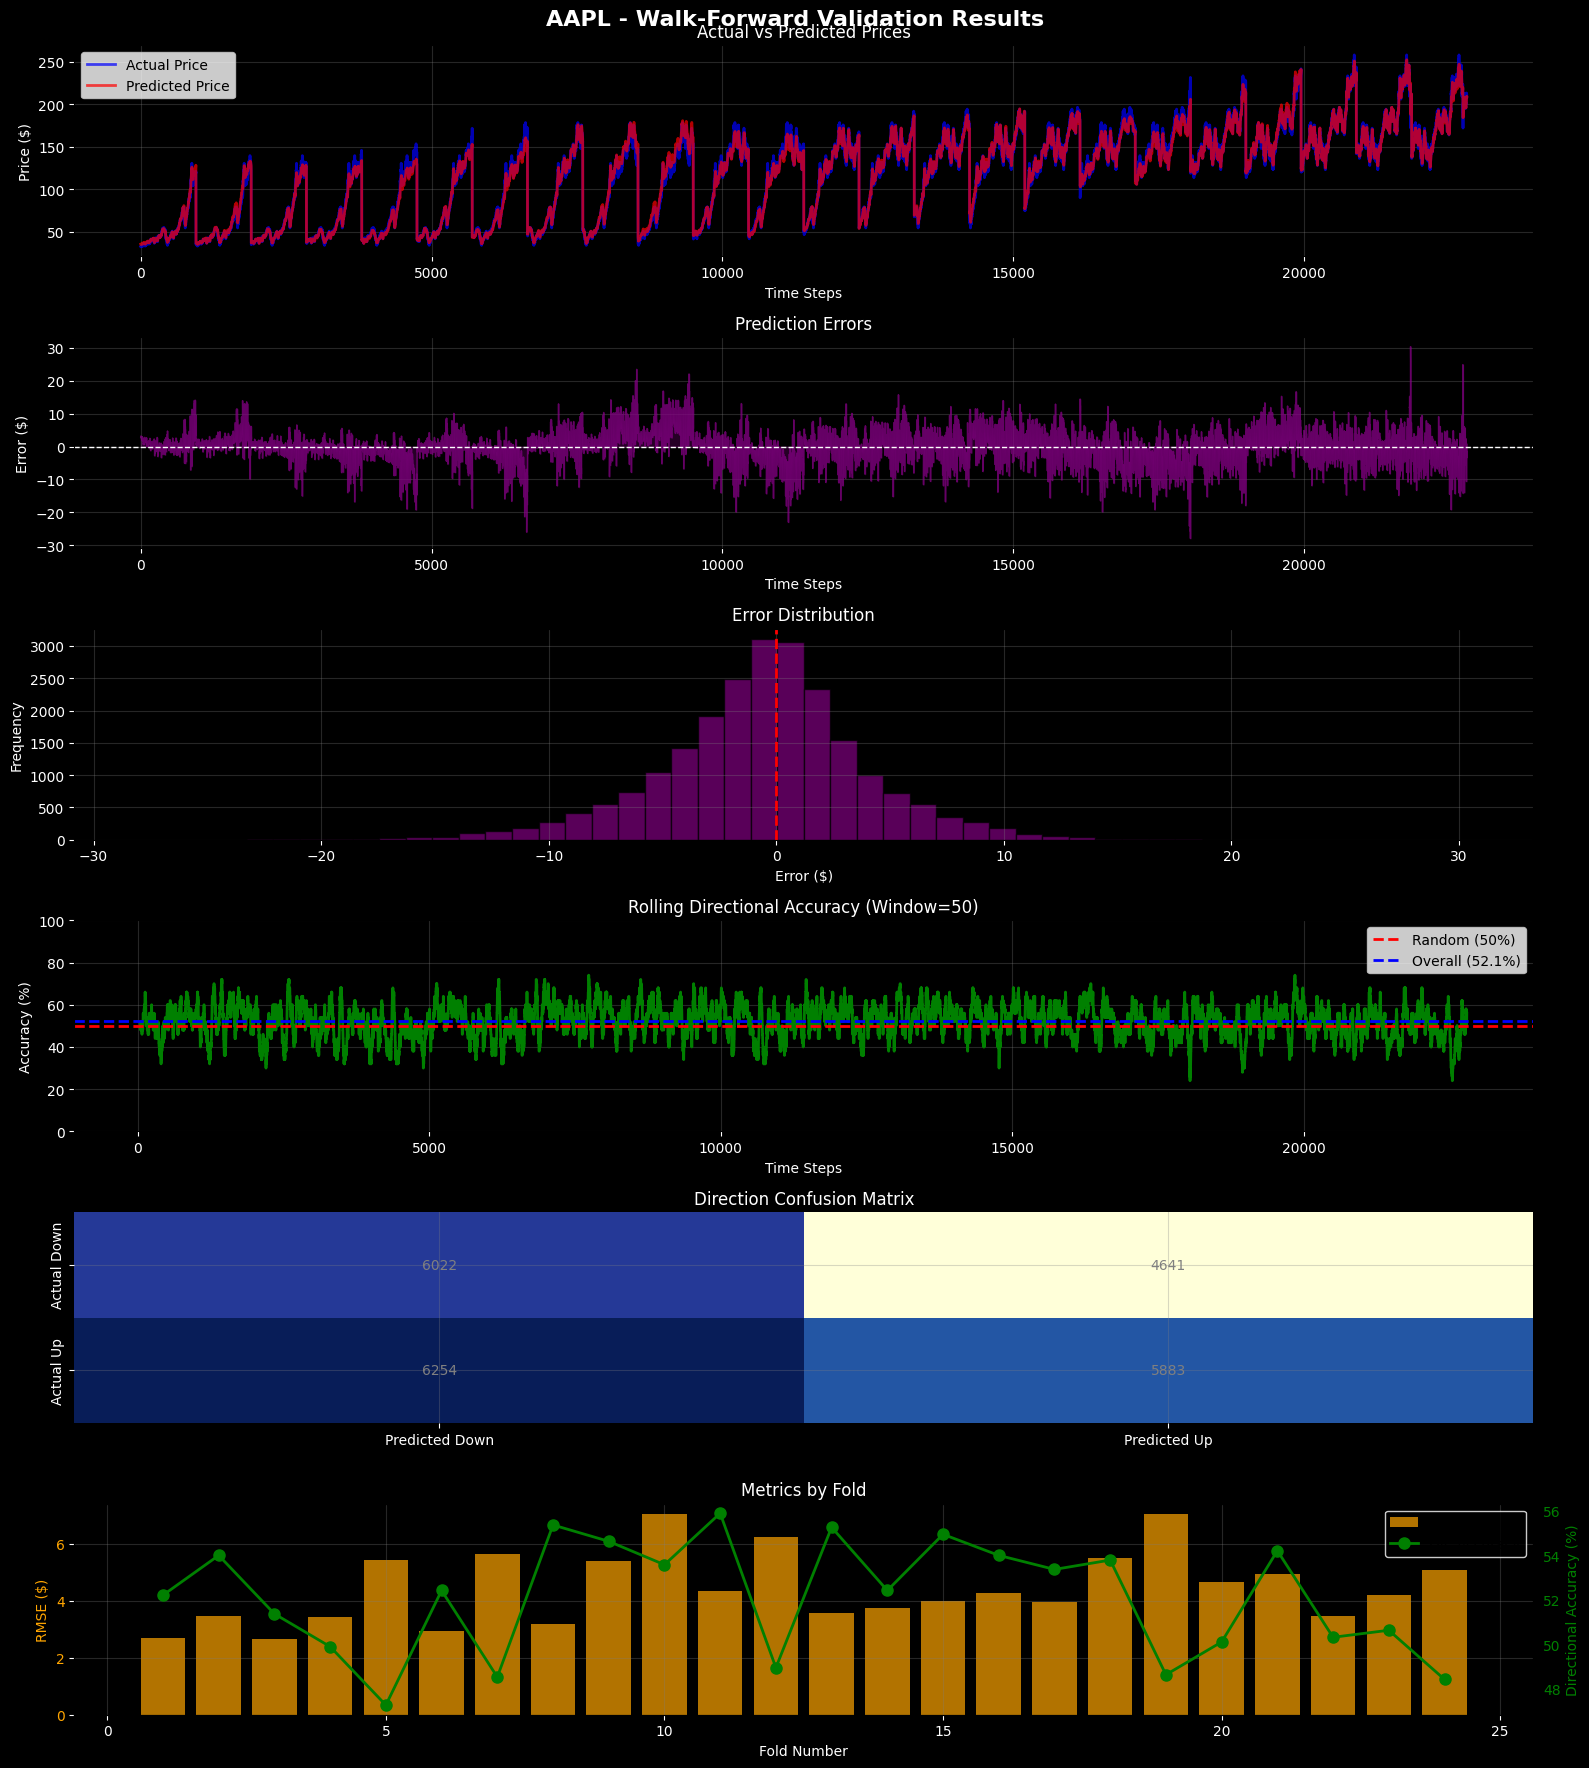

In [8]:
# ============================================================================
# 6. VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(6, 1, figsize=(16, 18), facecolor='black')  # 6x1 layout, black background
fig.suptitle(f'{ticker} - Walk-Forward Validation Results', fontsize=16, fontweight='bold', color='white')

# Set background color for all axes
for ax in axes:
    ax.set_facecolor('black')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='gray', alpha=0.3)  # Light grid lines for contrast

# Plot 1: Price Predictions
axes[0].plot(actuals, 'b-', label='Actual Price', linewidth=2, alpha=0.7)
axes[0].plot(predictions, 'r-', label='Predicted Price', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Time Steps', color='white')
axes[0].set_ylabel('Price ($)', color='white')
axes[0].set_title('Actual vs Predicted Prices', color='white')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Prediction Errors
errors = predictions - actuals
axes[1].plot(errors, 'purple', linewidth=1, alpha=0.7)
axes[1].axhline(y=0, color='white', linestyle='--', linewidth=1)
axes[1].fill_between(range(len(errors)), errors, 0, alpha=0.3, color='purple')
axes[1].set_xlabel('Time Steps', color='white')
axes[1].set_ylabel('Error ($)', color='white')
axes[1].set_title('Prediction Errors', color='white')
axes[1].grid(True, alpha=0.3)

# Plot 3: Error Distribution
axes[2].hist(errors, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Error ($)', color='white')
axes[2].set_ylabel('Frequency', color='white')
axes[2].set_title('Error Distribution', color='white')
axes[2].grid(True, alpha=0.3)

# Plot 4: Directional Accuracy
actual_dir = np.sign(actuals - previous)
pred_dir = np.sign(predictions - previous)
correct = (actual_dir == pred_dir).astype(int)

window = 50
rolling_accuracy = pd.Series(correct).rolling(window=window).mean() * 100

axes[3].plot(rolling_accuracy, 'green', linewidth=2)
axes[3].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Random (50%)')
axes[3].axhline(y=overall_metrics['Directional_Accuracy'], color='blue',
                linestyle='--', linewidth=2, label=f"Overall ({overall_metrics['Directional_Accuracy']:.1f}%)")
axes[3].set_xlabel('Time Steps', color='white')
axes[3].set_ylabel('Accuracy (%)', color='white')
axes[3].set_title(f'Rolling Directional Accuracy (Window={window})', color='white')
axes[3].legend()
axes[3].grid(True, alpha=0.3)
axes[3].set_ylim([0, 100])

# Plot 5: Confusion Matrix
cm = np.array([[overall_metrics['True_Negatives'], overall_metrics['False_Positives']],
               [overall_metrics['False_Negatives'], overall_metrics['True_Positives']]])
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=axes[4],
            xticklabels=['Predicted Down', 'Predicted Up'],
            yticklabels=['Actual Down', 'Actual Up'], cbar=False,
            annot_kws={"color": "gray"})
axes[4].set_title('Direction Confusion Matrix', color='white')


# Plot 6: Metrics by Fold
fold_indices = range(1, len(fold_metrics) + 1)
rmse_by_fold = [m['RMSE'] for m in fold_metrics]
dir_acc_by_fold = [m['Directional_Accuracy'] for m in fold_metrics]

ax6 = axes[5]
ax6_twin = ax6.twinx()

ax6.bar(fold_indices, rmse_by_fold, alpha=0.7, color='orange', label='RMSE')
ax6_twin.plot(fold_indices, dir_acc_by_fold, 'go-', linewidth=2, markersize=8, label='Dir. Accuracy')

ax6.set_xlabel('Fold Number', color='white')
ax6.set_ylabel('RMSE ($)', color='orange')
ax6_twin.set_ylabel('Directional Accuracy (%)', color='green')
ax6.set_title('Metrics by Fold', color='white')
ax6.tick_params(axis='y', labelcolor='orange')
ax6_twin.tick_params(axis='y', labelcolor='green')
ax6.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right', facecolor='black', edgecolor='white')

plt.tight_layout()
plt.show()
